# Bayesian riddle
> The typical bayesian interview question, solved with PyMC3

- comments: true
- badges: true
- categories: [random]
- publishes: true

Here is a statement I saw multiple times online. I also received it once during a Data Science interview. I was not sure at first how to fully solve it. 

# The problem:

You're about to get on a plane to Seattle. You want to know if you should bring an umbrella. You call 3 random friends of yours who live there and ask each independently if it's raining. Each of your friends has a 2/3 chance of telling you the truth and a 1/3 chance of messing with you by lying. All 3 friends tell you that "Yes" it is raining. What is the probability that it's actually raining in Seattle?

# A first way to solve it

You can solve the problem by applying the rule of bayes. 

We are looking for the probability that it rains, given that we had 3 yes. 
This can be reformulated as the probability that we have 3 yes, given that it rains, time the probability that it rains, divided by the probability of having 3 yes. 

## Using the bayes formula

p(rain | 3xYes) = (p(3xYes | rain ) * p(rain)) / P(3xYes)

p(rain | 3xYes) = (((2/3)^3 ) * p(rain)) / P(3xYes)

p(rain | 3xYes) = ((8/27) * p(rain)) / P(3xYes)

p(rain | 3xYes) = ((8/27) * p(rain)) / (P(3xYes | rain) p(rain) + P(3xYes | not_rain) p (not_rain))

p(rain | 3xYes) = ((8/27) * p(rain)) / (8/27) p(rain) + (1/27) p (not_rain))

p(rain | 3xYes) = ((8) * p(rain)) / (8 p(rain) + ( 1- p (rain) ))

p(rain | 3xYes) = ((8) * p(rain)) / (7 p(rain) + ( 1 ))


## Choosin a prior

Now that you did that, you are left with a formula that depends on the probability that it rains. You can choose a prior for what you consider your a-priori belief on the chances of raining, and plug it in. 

For example, if you chose the prior p(rain) = 0.5, it gives. 

p(rain | 3xYes) = 0.8888

# Quantifying uncertainty

However, that solution seems incomplete to me. 
When we say we have a prior of p(rain) = 0.5, what is our confidence in that prior ? If we are absolutely certain, then new information should not influence us. If 0.5 was just a random guess, than we should only use new information. 

For that reason, I think it is more complete to state the problem using distributions to represent our belief. 

Now, how do you represent your belief regarding the rain event ? This took me a while to figure out. But rain is a Bernouilli event. It either happens, or not. And there is a probability that it happens. You should not model the rain event using another distribution. 

The place where you should model your uncertainty is in the *probability* that it rains. So, not in the rain Bernouilli event, but in the probability _p_rain_ of that Bernouilli event. 

If we use PyMC3 to model that, we would do something as follows: 

In [11]:
import pymc3 as pm
with pm.Model() as model: 
    p_rain = pm.Uniform("p_rain", 0, 1)
    rain = pm.Bernoulli("rain", p=p_rain)

We now model a Bernouilli event and we represented our uncertainty regarding its probability of happening useing a Beta distribution. As we don't have any a-priori, we put a uniform distribution between 0 and 1

The next step is to model the answers of our friends to our question. A friend answering yes or no is also a Bernouilli trial. So we will model it using a Bernouilli distribution. But what is the probability of that distribution ? It is the probability that there is rain, that we can get from our _rain_ variable above, transformed by the fact that our friends are liars. 

Here is how you can do that

In [12]:
with model: 
    p_yes = rain * 2/3 + (1-rain) * 1/3
    likelihood = pm.Bernoulli("likelihood", p=p_yes, observed=[1,1,1])

First we transform the rain event into a probability of saying yes. Then we use that probability into a Bernouilli distribution. This is the distribution of the even "a friend is saying yes". So this is the distribution where we observed 3 samples: Yes, Yes and Yes. This is why I put in `observed=[1,1,1]`

With all that done, we can now as PyMC3 to solve the system and find wich values of `p_rain` make the most sense with the observed data. This means updating our prior with our new knowledge.

You do it as such: 

<ipython-input-13-c24b15fb0137>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5_000, chains=2)
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p_rain]
>BinaryGibbsMetropolis: [rain]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 14 seconds.
<ipython-input-13-c24b15fb0137>:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/Users/rodolphe_cambier/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'rain'}>,
        <AxesSubplot:title={'center':'rain'}>],
       [<AxesSubplot:title={'center':'p_rain'}>,
        <AxesSubplot:title={'center':'p_rain'}>]], dtype=object)

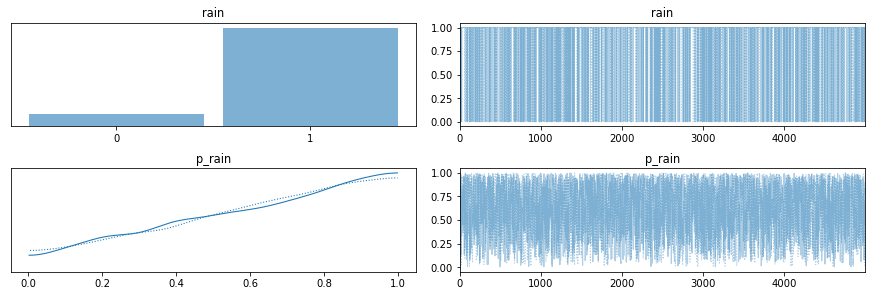

In [13]:
with model: 
    trace = pm.sample(5_000, chains=2)
pm.traceplot(trace)

So we started with a flat a-priori for `p_rain` and we end up with this curve. 

We can check what is now the expected value of the `rain` Bernouilli distribution: 

In [14]:
with model: 
    samples = pm.sample_posterior_predictive(trace, var_names=["rain"], samples=10_000)
    print("Posterior sampling of rain: ", samples['rain'].mean())

Posterior sampling of rain:  0.8909


This is almost the same value as the formula we used above !
But now we have the nice advantage of being able to specify our confidence in that value. We can share the plot of the `p_rain` distribution and say that this is, for us, the most likely values. 

# Using an informative prior

We can also use a prior where we include some a-priori knowledge. 
For example, if we know that it rained 150 days last year, we could use a beta distribution with alpha=150 and beta=215 to represent that knowledge. 

<ipython-input-16-7289630af5f7>:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5_000, chains=2)
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p_rain]
>BinaryGibbsMetropolis: [rain]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 13 seconds.


Posterior sampling of rain:  0.8445


<ipython-input-16-7289630af5f7>:9: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/Users/rodolphe_cambier/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'rain'}>,
        <AxesSubplot:title={'center':'rain'}>],
       [<AxesSubplot:title={'center':'p_rain'}>,
        <AxesSubplot:title={'center':'p_rain'}>]], dtype=object)

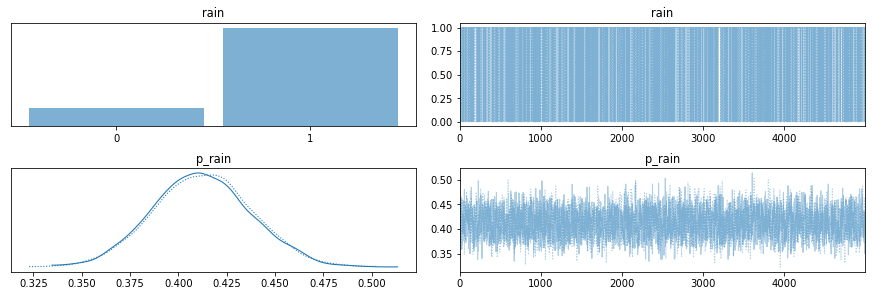

In [16]:
with pm.Model() as model: 
  p_rain = pm.Beta("p_rain", 150, 215) 
  rain = pm.Bernoulli("rain", p=p_rain) 
  p_yes = rain * 2/3 + (1-rain) * 1/3 
  likelihood = pm.Bernoulli("likelihood", p=p_yes, observed=[1,1,1]) 
  trace = pm.sample(5_000, chains=2)
  samples = pm.sample_posterior_predictive(trace, var_names=["rain"], samples=10_000)
  print("Posterior sampling of rain: ", samples['rain'].mean())
pm.traceplot(trace)

The chances of rain are now 0.8445. This is less than before. 
Notice also how our `p_rain` distribution represents a different belief. 